In [649]:
import bagpy
import rospy
from shapely import affinity
from bagpy import bagreader
import pandas as pd
import seaborn as sea
import numpy as np
from matplotlib import pyplot, patches
from matplotlib.patches import Circle
from shapely.geometry import Polygon, Point, MultiPoint, LineString, MultiLineString
from descartes.patch import PolygonPatch
import random
from figures import BLUE, WHITE, RED, GREEN, SIZE, set_limits, plot_coords, color_isvalid, plot_line
from scipy.interpolate import make_interp_spline, BSpline, CubicSpline

DRONE1 = '#00FF00'
DRONE2 = '#FF0000'
DRONE3 = '#0000FF'
DRONE4 = '#FF00FF'
BLUE = '#6699cc'
BLACK = '#000000'
pyplot.rcParams.update({'font.size': 22})


In [650]:
b = bagreader('/home/kaka/catkin_ws/src/multi_drone_sar/data/bagfiles/200_trees_people_clustered_1000_238/2021-05-07-18-58-10.bag') 

[INFO]  Successfully created the data folder /home/kaka/catkin_ws/src/multi_drone_sar/data/bagfiles/200_trees_people_clustered_1000_238/2021-05-07-18-58-10.


In [651]:
b.topic_table

,Topics,Types,Message Count,Frequency
0,/airsim_node/drone_1/distance/Distance,sensor_msgs/Range,25604,40.359728
1,/airsim_node/drone_1/environment,airsim_ros_pkgs/Environment,25604,40.354292
2,/airsim_node/drone_1/global_gps,sensor_msgs/NavSatFix,25604,40.355456
3,/airsim_node/drone_1/imu/Imu,sensor_msgs/Imu,25604,40.449249
4,/airsim_node/drone_1/lidar/LidarCustom,sensor_msgs/PointCloud2,64634,5957.818182
...,...,...,...,...
129,/rosout_agg,rosgraph_msgs/Log,1027,13.726591
130,/task_manager/available,multi_drone_sar/TaskArray,7789,10.070890
131,/task_manager/taken,multi_drone_sar/TaskArray,7789,10.050546
132,/tf,tf2_msgs/TFMessage,109812,340.087894


In [652]:
WP_STATUS_ONE = b.message_by_topic('/drone_1/navigation/status')
WP_STATUS_TWO = b.message_by_topic('/drone_2/navigation/status')
WP_STATUS_THREE = b.message_by_topic('/drone_3/navigation/status')
WP_STATUS_FOUR = b.message_by_topic('/drone_4/navigation/status')

In [653]:
wp_status_message_one = pd.read_csv(WP_STATUS_ONE)
wp_status_message_two = pd.read_csv(WP_STATUS_TWO)
wp_status_message_three = pd.read_csv(WP_STATUS_THREE)
wp_status_message_four = pd.read_csv(WP_STATUS_FOUR)

In [654]:
drone_wps_one = wp_status_message_one.loc[wp_status_message_one['goal_id.id'].astype(str).str.isnumeric()]
drone_wps_one = drone_wps_one.loc[np.logical_and(drone_wps_one['status'] == 3 , drone_wps_one['goal_id.id'].astype(int) < 100), 'goal_id.id'].astype(int)

drone_wps_two = wp_status_message_two.loc[wp_status_message_two['goal_id.id'].astype(str).str.isnumeric()]
drone_wps_two = drone_wps_two.loc[np.logical_and(drone_wps_two['status'] == 3 , drone_wps_two['goal_id.id'].astype(int) < 100), 'goal_id.id'].astype(int)

drone_wps_three = wp_status_message_three.loc[wp_status_message_three['goal_id.id'].astype(str).str.isnumeric()]
drone_wps_three = drone_wps_three.loc[np.logical_and(drone_wps_three['status'] == 3 , drone_wps_three['goal_id.id'].astype(int) < 100), 'goal_id.id'].astype(int)

drone_wps_four = wp_status_message_four.loc[wp_status_message_four['goal_id.id'].astype(str).str.isnumeric()]
drone_wps_four = drone_wps_four.loc[np.logical_and(drone_wps_four['status'] == 3, drone_wps_four['goal_id.id'].astype(int) < 100), 'goal_id.id'].astype(int)

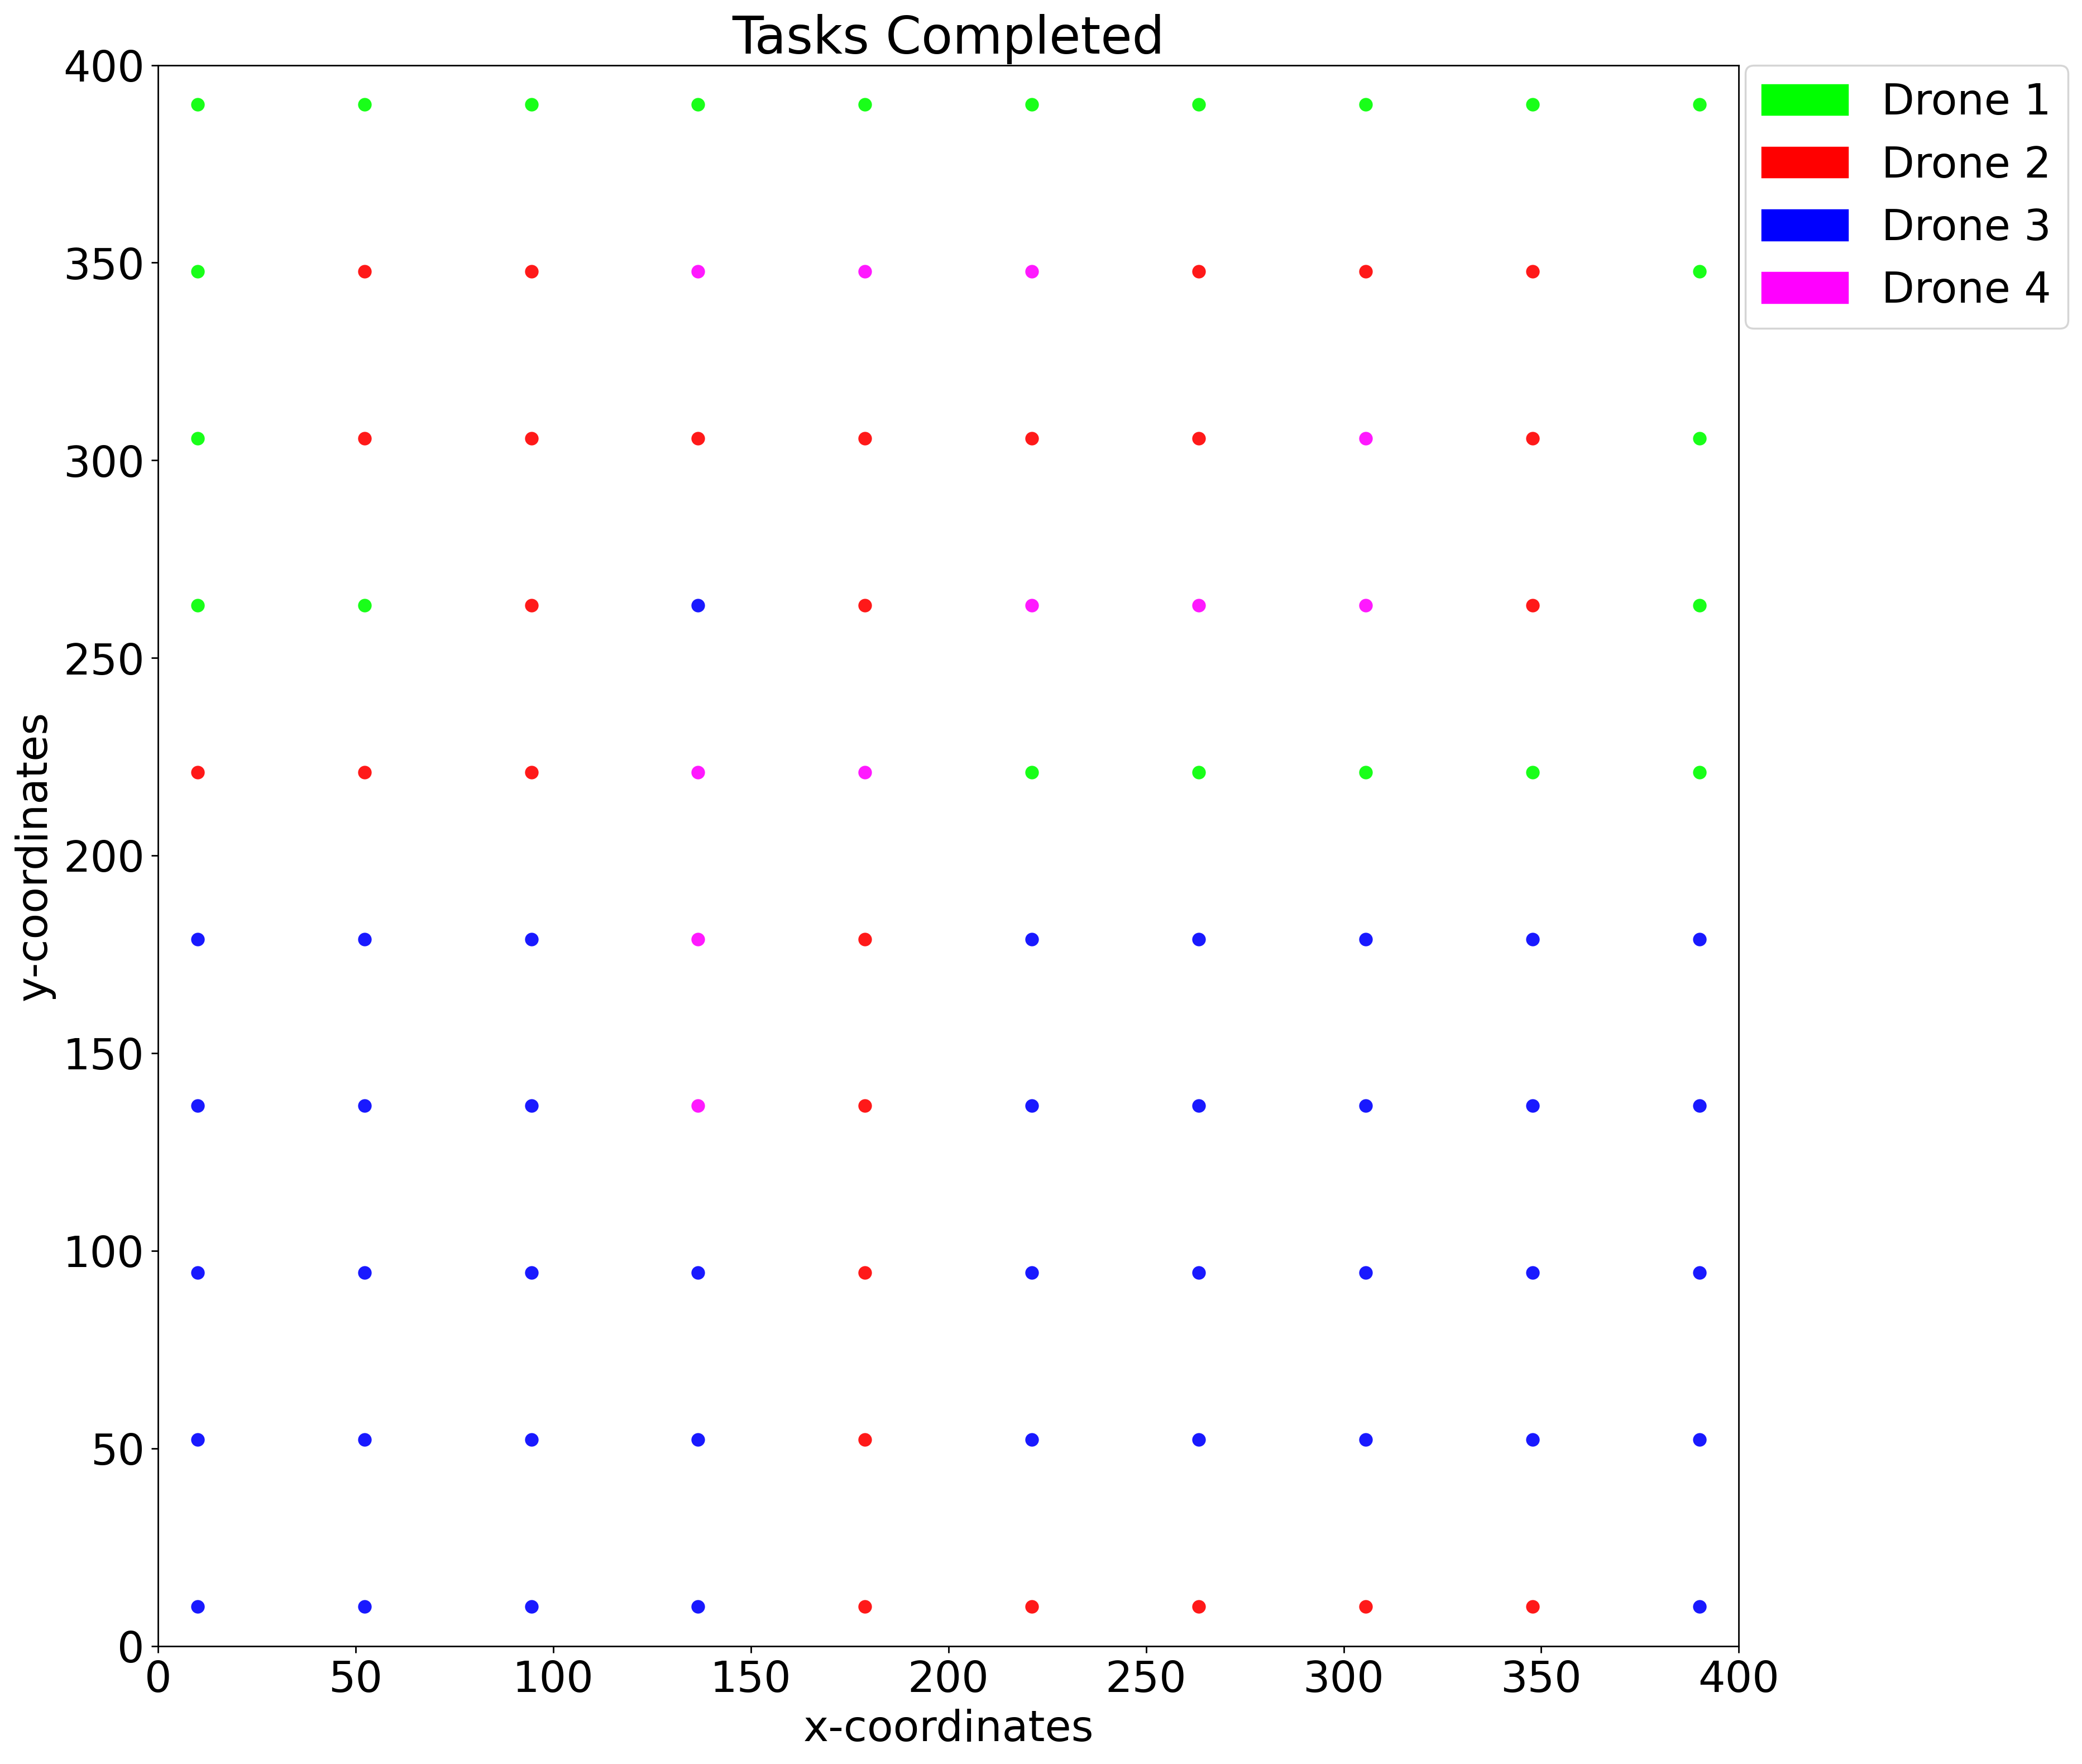

In [655]:
pyplot.rcParams.update({'font.size': 22})

fig = pyplot.figure(1, figsize=(20, 15.0), dpi=250)
fig1 = fig.add_subplot(111)

big_square = [(0, 0), (0, 400), (400, 400), (400, 0), (0, 0)]
polygon_big = Polygon(big_square)
patch1 = PolygonPatch(polygon_big, facecolor=WHITE, edgecolor=color_isvalid(polygon_big, valid=WHITE), alpha=0.1, zorder=2)
fig1.add_patch(patch1)
fig1.set_title('Tasks Completed')
set_limits(fig1, 0, 400, 0, 400, 50)

#points = random_points_within(polygon_big, 50)

x = np.linspace(10, 390, 10)
y = np.linspace(10, 390, 10)
points = MultiPoint(np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]))
points = affinity.scale(points, xfact=-1)
points = affinity.rotate(points, -90)
for idx, point in enumerate(points):
    if drone_wps_one.isin([idx]).any():
        plot_coords(fig1, point, color=DRONE1)
    if drone_wps_two.isin([idx]).any():
        plot_coords(fig1, point, color=DRONE2)
    if drone_wps_three.isin([idx]).any():
        plot_coords(fig1, point, color=DRONE3)
    if drone_wps_four.isin([idx]).any():
        plot_coords(fig1, point, color=DRONE4)
pyplot.xlabel("x-coordinates")
pyplot.ylabel("y-coordinates")
green_patch = patches.Patch(color=DRONE1, label='Drone 1')
red_patch = patches.Patch(color=DRONE2, label='Drone 2')
blue_patch = patches.Patch(color=DRONE3, label='Drone 3')
purple_patch = patches.Patch(color=DRONE4, label='Drone 4')
pyplot.legend(handles=[green_patch, red_patch, blue_patch, purple_patch], bbox_to_anchor=(1.004, 1), loc='upper left', borderaxespad=0.)
pyplot.savefig(f'{b.datafolder}/tasks_completed.pdf', bbox_inches='tight', dpi=600)
pyplot.show()

In [656]:
ODOM_STATUS_ONE = b.message_by_topic('/airsim_node/drone_1/odom_local_ned')
odom_status_message_one = pd.read_csv(ODOM_STATUS_ONE)
drone_odom_x_one = odom_status_message_one['pose.pose.position.x']
drone_odom_y_one = odom_status_message_one['pose.pose.position.y']
drone_odom_hseq_one = odom_status_message_one['header.seq']

ODOM_STATUS_TWO = b.message_by_topic('/airsim_node/drone_2/odom_local_ned')
odom_status_message_two = pd.read_csv(ODOM_STATUS_TWO)
drone_odom_x_two = odom_status_message_two['pose.pose.position.x']
drone_odom_y_two = odom_status_message_two['pose.pose.position.y']

ODOM_STATUS_THREE = b.message_by_topic('/airsim_node/drone_3/odom_local_ned')
odom_status_message_three = pd.read_csv(ODOM_STATUS_THREE)
drone_odom_x_three = odom_status_message_three['pose.pose.position.x']
drone_odom_y_three = odom_status_message_three['pose.pose.position.y']

ODOM_STATUS_FOUR = b.message_by_topic('/airsim_node/drone_4/odom_local_ned')
odom_status_message_four = pd.read_csv(ODOM_STATUS_FOUR)
drone_odom_x_four = odom_status_message_four['pose.pose.position.x']
drone_odom_y_four = odom_status_message_four['pose.pose.position.y']


In [657]:
drone_1_y = np.array(list(drone_odom_x_one[::25]))+200
drone_1_x = np.array(list(drone_odom_y_one[::25]))-30
drone_odom_hseq_one = drone_odom_hseq_one.tolist()
drone_odom_hseq_one = drone_odom_hseq_one[::25]
drone_1_points = MultiPoint([list(pair) for pair in zip(drone_1_x, drone_1_y)])

drone_2_y = np.array(list(drone_odom_x_two[::25]))+200
drone_2_x = np.array(list(drone_odom_y_two[::25]))-30
drone_2_points = MultiPoint([list(pair) for pair in zip(drone_2_x, drone_2_y)])

drone_3_y = np.array(list(drone_odom_x_three[::25]))+200
drone_3_x = np.array(list(drone_odom_y_three[::25]))-30
drone_3_points = MultiPoint([list(pair) for pair in zip(drone_3_x, drone_3_y)])

drone_4_y = np.array(list(drone_odom_x_four[::25]))+200
drone_4_x = np.array(list(drone_odom_y_four[::25]))-30
drone_4_points = MultiPoint([list(pair) for pair in zip(drone_4_x, drone_4_y)])

all_drones_y = np.concatenate((drone_1_y, drone_2_y, drone_3_y, drone_4_y))
all_drones_x = np.concatenate((drone_1_x, drone_2_x, drone_3_x, drone_4_x))
all_drones_points = MultiPoint([list(pair) for pair in zip(all_drones_x, all_drones_y)])

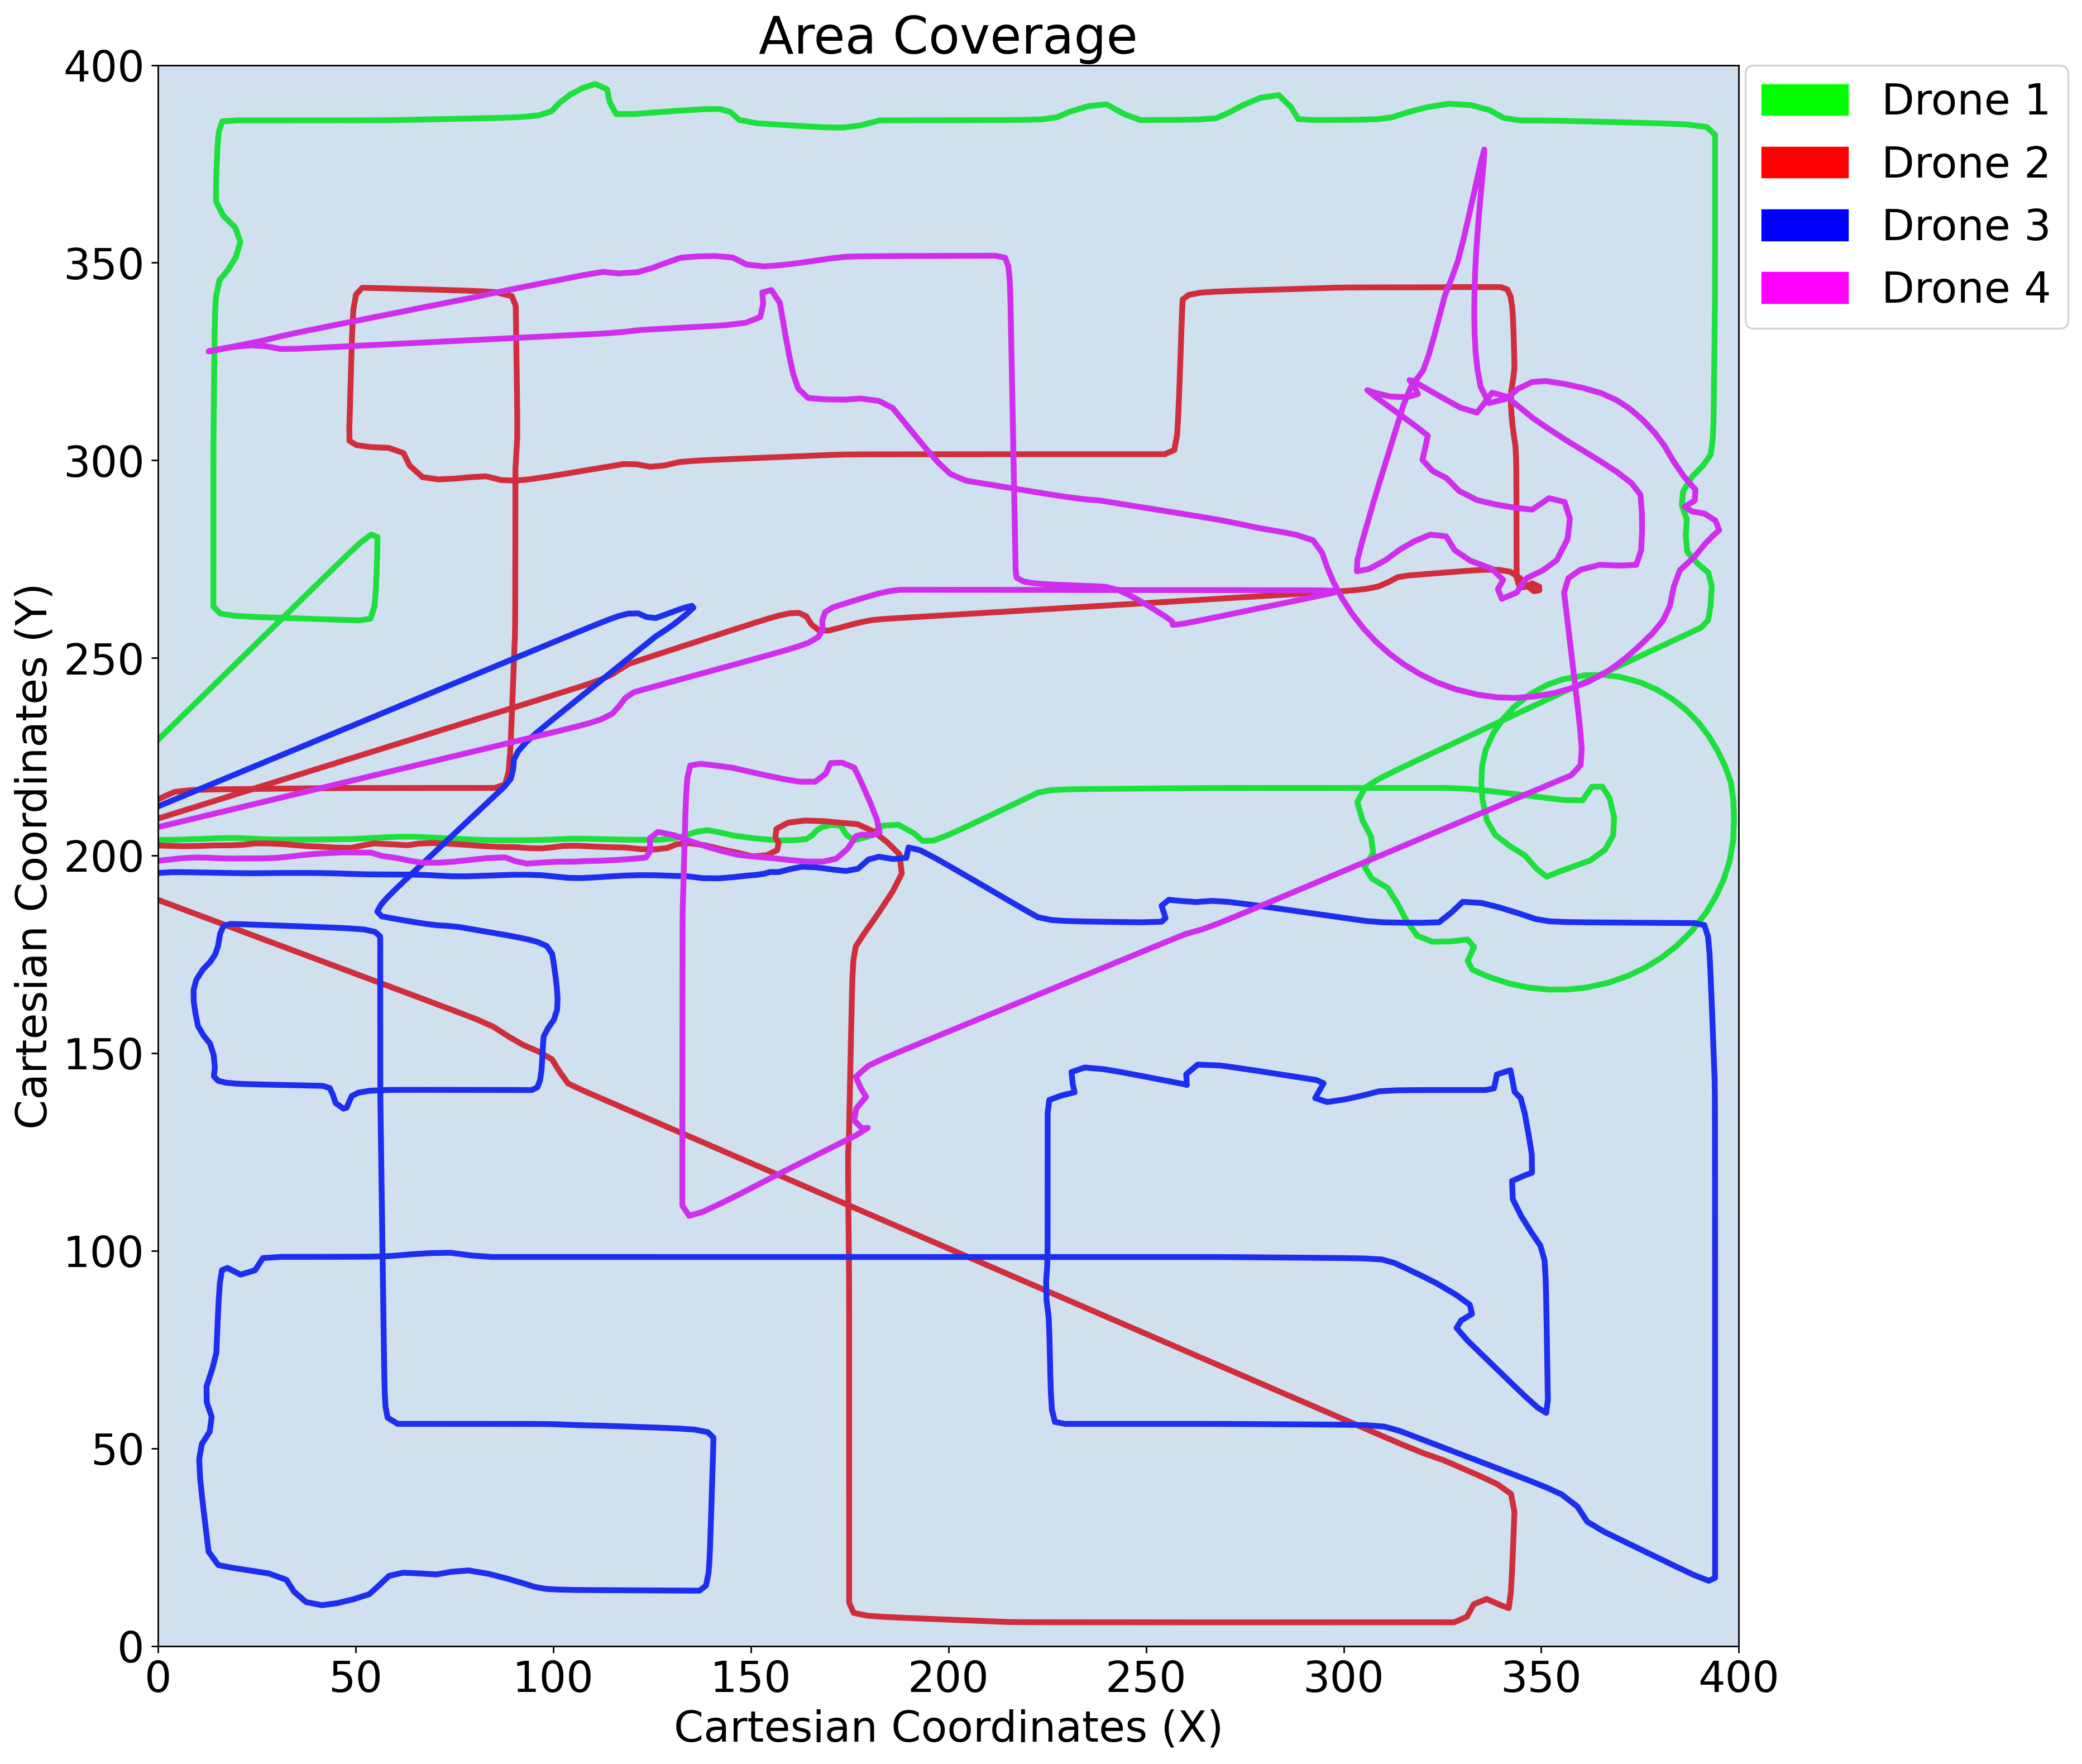

In [658]:
line1 = LineString(drone_1_points)
line2 = LineString(drone_2_points)
line3 = LineString(drone_3_points)
line4 = LineString(drone_4_points)
line5 = LineString(all_drones_points)
fig = pyplot.figure(1, figsize=(20, 15.0), dpi=250)

ax = fig.add_subplot(111)

dilated1 = line5.buffer(30, join_style=1)

patch1 = PolygonPatch(dilated1, fc=BLUE, ec=BLUE, alpha=0.3, zorder=2)

ax.add_patch(patch1)

plot_line(ax, line1, color=DRONE1)
plot_line(ax, line2, color=DRONE2)
plot_line(ax, line3, color=DRONE3)
plot_line(ax, line4, color=DRONE4)

ax.set_title('Area Coverage')
green_patch = patches.Patch(color=DRONE1, label='Drone 1')
red_patch = patches.Patch(color=DRONE2, label='Drone 2')
blue_patch = patches.Patch(color=DRONE3, label='Drone 3')
purple_patch = patches.Patch(color=DRONE4, label='Drone 4')
pyplot.legend(handles=[green_patch, red_patch, blue_patch, purple_patch], bbox_to_anchor=(1.004, 1), loc='upper left', borderaxespad=0.)
pyplot.xlabel(xlabel='Cartesian Coordinates (X)')
pyplot.ylabel(ylabel='Cartesian Coordinates (Y)')
set_limits(ax, 0, 400, 0, 400, 50)
pyplot.savefig(f'{b.datafolder}/area_coverage.pdf', bbox_inches='tight', dpi=600)

In [659]:
drone_individual_path_length = [line1.length, line2.length, line3.length, line4.length]

In [660]:
difference = polygon_big.difference(dilated1)
polygon_big.area; # TOTAL AREA OF MAP
difference.area # AREA THAT HAS _NOT_ BEEN COVERED
covered_area = polygon_big.area - difference.area
covered_area_percentage = (covered_area  / polygon_big.area) * 100

In [661]:
difference

In [662]:
PAT_STATUS = b.message_by_topic('/people_and_time')
pat_status_message = pd.read_csv(PAT_STATUS)
time = pat_status_message['Time'].tolist()
people_found = pat_status_message['people_found'].tolist()
new_time = []
total_people_temp = pat_status_message['total_people'].tolist()
total_people = total_people_temp[0]
time_ros = pat_status_message.loc[pat_status_message['people_found'] == total_people, 'Time']
temp_time = time_ros.tolist()
all_people_found_time = temp_time[0] - time[0]

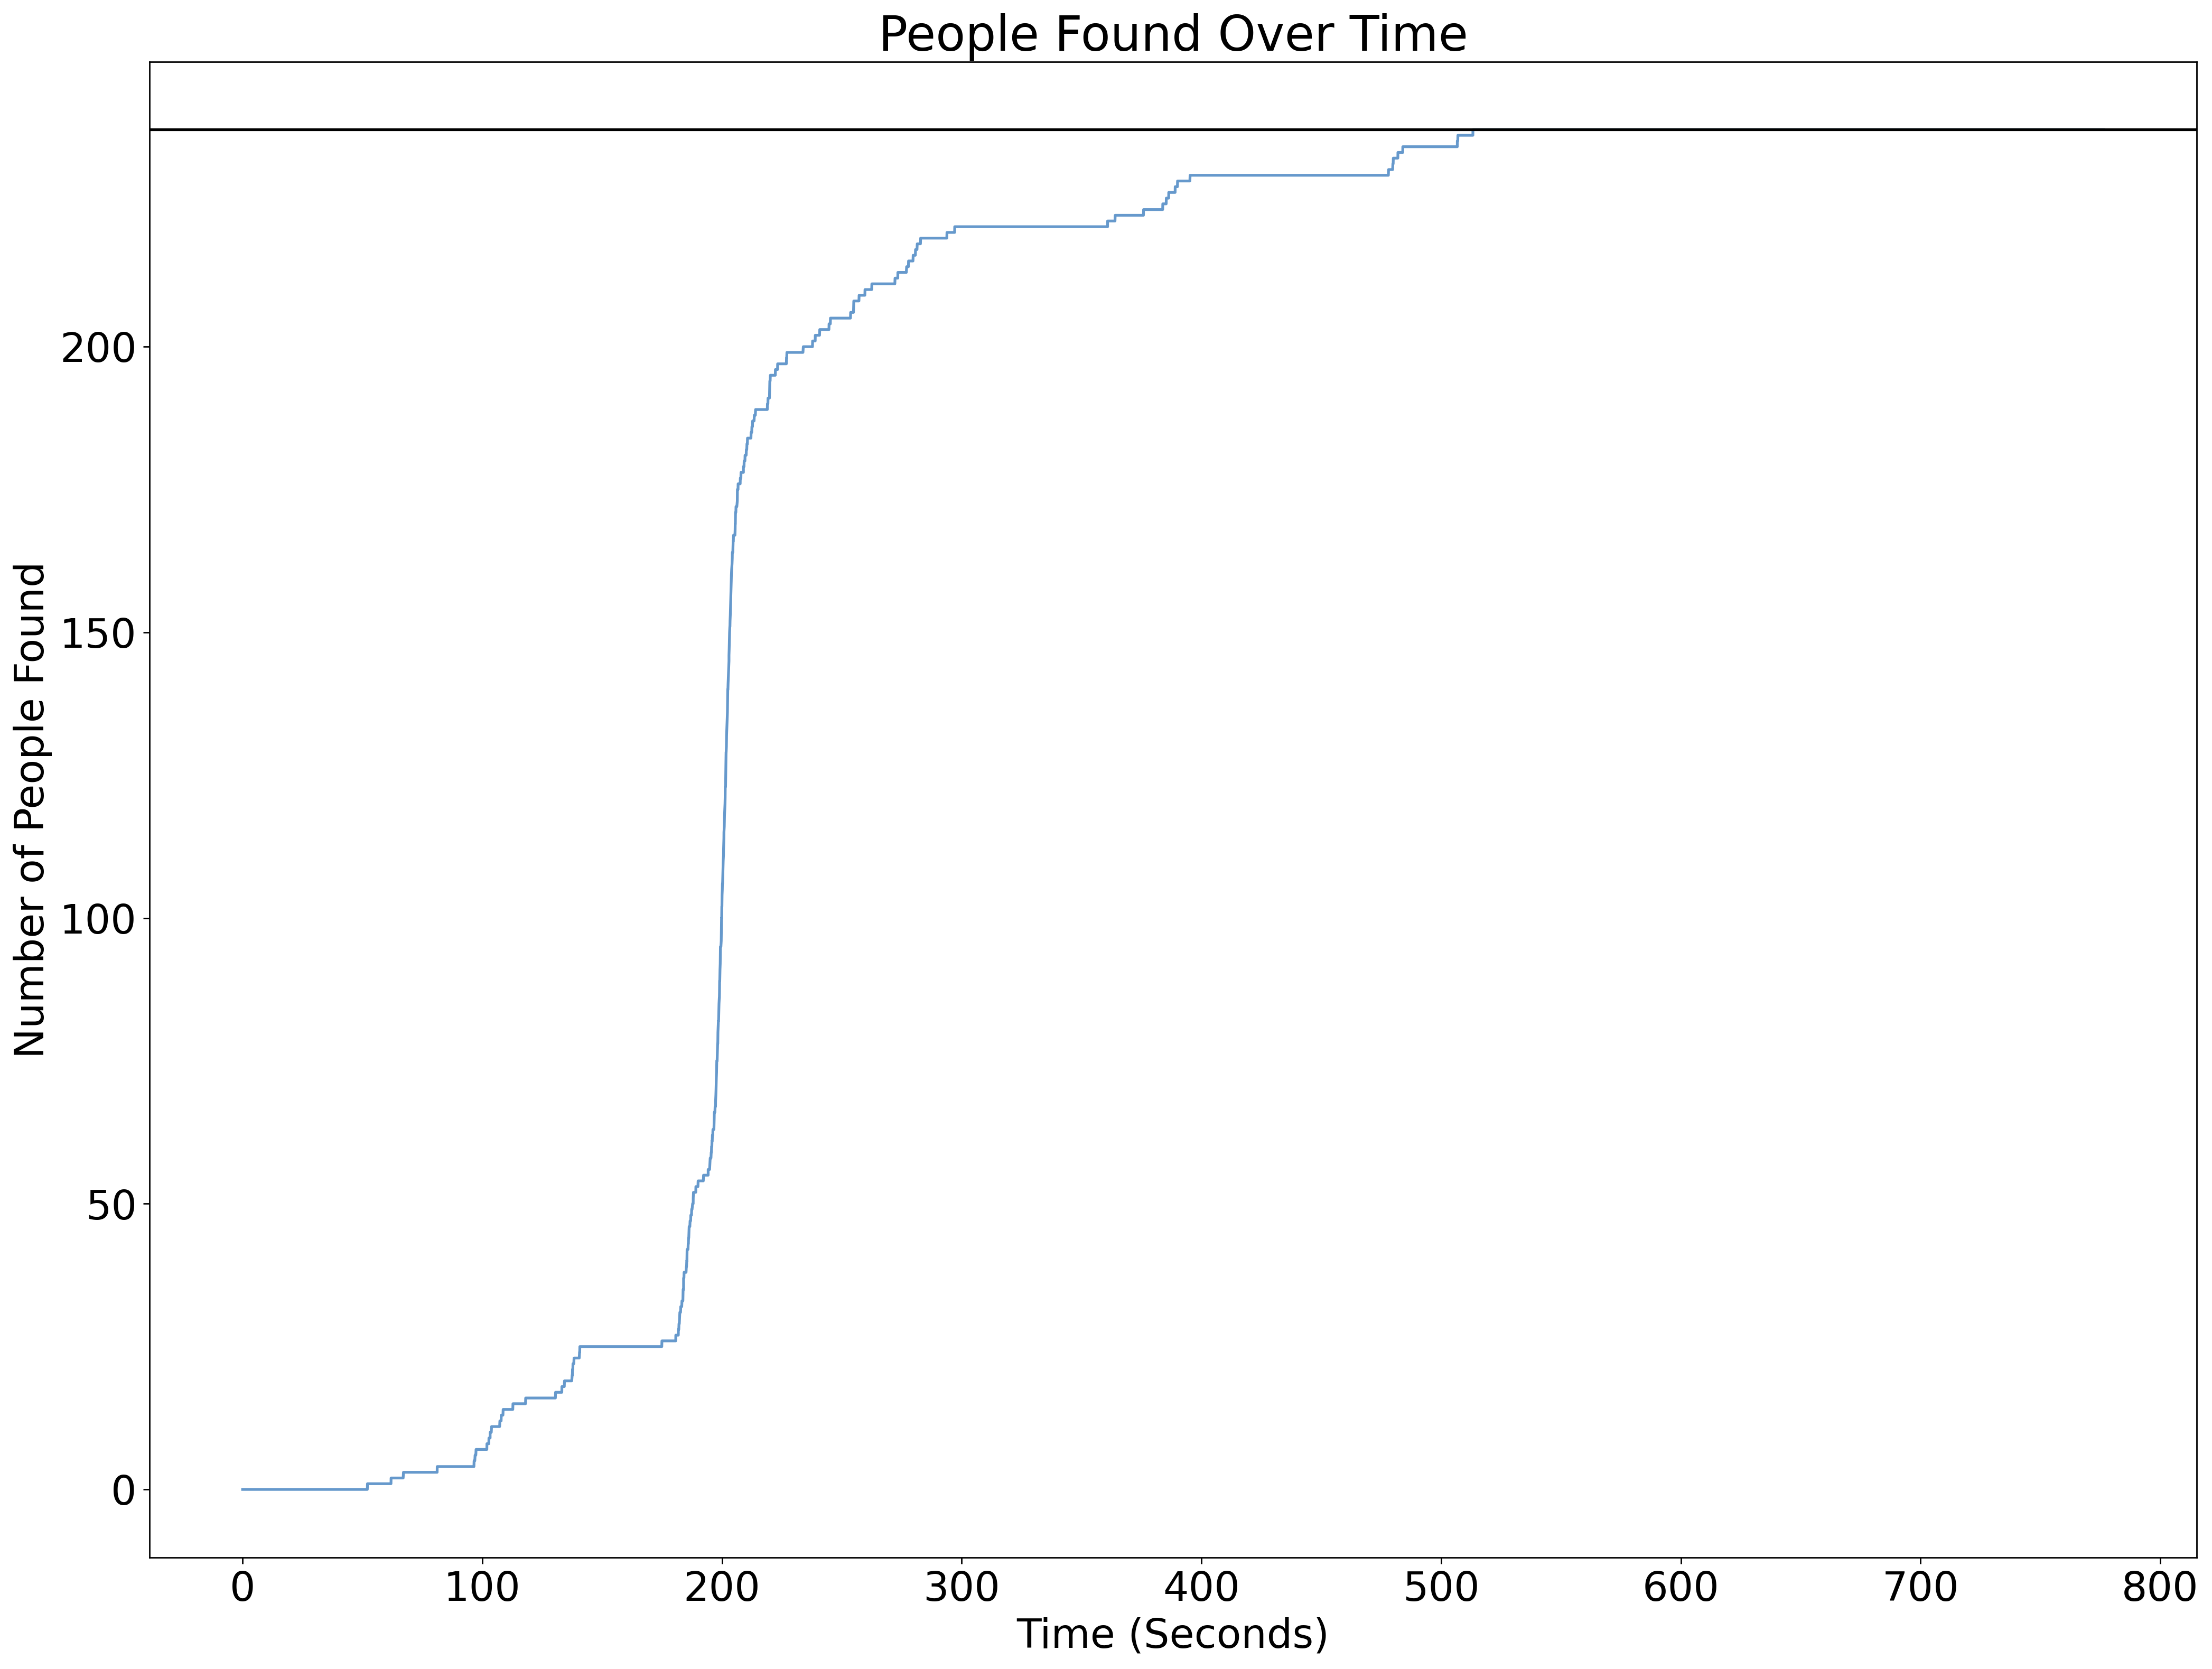

In [663]:
for idx, t in enumerate(time):
    new_time.append(t - time[0])
pyplot.figure(1, figsize=(20, 15.0), dpi=250)
pyplot.plot(new_time, people_found, color=BLUE)
pyplot.axhline(y=total_people, color=BLACK, linestyle='-')
pyplot.ylabel('Number of People Found')
pyplot.xlabel('Time (Seconds)')
pyplot.title('People Found Over Time')
pyplot.savefig(f'{b.datafolder}/people_found_over_time.pdf', bbox_inches='tight', dpi=600)
pyplot.show()

In [664]:
total_time_list = pat_status_message['Time'].tolist()
total_time = int(total_time_list[-1] - time[0])

In [665]:
covered_area_percentage_pad = []
area_coverage_counter25 = 0
area_coverage_counter50 = 0
area_coverage_counter75 = 0
area_coverage_counter95 = 0
mission_complete_time_100 = [total_time_list[-1]]
for idx, (d1x, d1y, d2x, d2y, d3x, d3y, d4x, d4y) in enumerate(zip(drone_1_x, drone_1_y, drone_2_x, drone_2_y, drone_3_x, drone_3_y, drone_4_x, drone_4_y)):
    if idx < 1:
        continue
    points = [
        MultiPoint([list(pair) for pair in zip(drone_1_x[:idx+1], drone_1_y[:idx+1])]),
        MultiPoint([list(pair) for pair in zip(drone_2_x[:idx+1], drone_2_y[:idx+1])]),
        MultiPoint([list(pair) for pair in zip(drone_3_x[:idx+1], drone_3_y[:idx+1])]),
        MultiPoint([list(pair) for pair in zip(drone_4_x[:idx+1], drone_4_y[:idx+1])]),
    ]
    area_cov_line = MultiLineString(points)
    #all_y = np.concatenate((drone_1_x[0:idx+1], drone_2_x[0:idx+1], drone_3_x[0:idx+1], drone_4_x[0:idx+1]))
    #all_x = np.concatenate((drone_1_y[0:idx+1], drone_2_y[0:idx+1], drone_3_y[0:idx+1], drone_4_y[0:idx+1]))
    #all_points = MultiPoint([list(pair) for pair in zip(all_x, all_y)])
    #area_cov_line = LineString(all_points)
    padding = area_cov_line.buffer(30, join_style=1)
    difference_pad = polygon_big.difference(padding)
    covered_area_pad = polygon_big.area - difference_pad.area
    covered_area_percentage_pad.append((covered_area_pad  / polygon_big.area) * 100)
    if area_coverage_counter25 == 0 and covered_area_percentage_pad[-1] > 25:
        area_coverage_counter25 += 1
        mission_complete_time_25 = odom_status_message_one.loc[odom_status_message_one['header.seq'] == drone_odom_hseq_one[idx], 'Time'].tolist()
    if area_coverage_counter50 == 0 and covered_area_percentage_pad[-1] > 50:
        area_coverage_counter50 += 1
        mission_complete_time_50 = odom_status_message_one.loc[odom_status_message_one['header.seq'] == drone_odom_hseq_one[idx], 'Time'].tolist()
    if area_coverage_counter75 == 0 and covered_area_percentage_pad[-1] > 75:
        area_coverage_counter75 += 1
        mission_complete_time_75 = odom_status_message_one.loc[odom_status_message_one['header.seq'] == drone_odom_hseq_one[idx], 'Time'].tolist()
    if area_coverage_counter95 == 0 and covered_area_percentage_pad[-1] > 95:
        area_coverage_counter95 += 1
        mission_complete_time_95 = odom_status_message_one.loc[odom_status_message_one['header.seq'] == drone_odom_hseq_one[idx], 'Time'].tolist()
    if covered_area_percentage_pad[-1] > 99.90:
        mission_complete_time_100 = odom_status_message_one.loc[odom_status_message_one['header.seq'] == drone_odom_hseq_one[idx], 'Time'].tolist()
        break
    


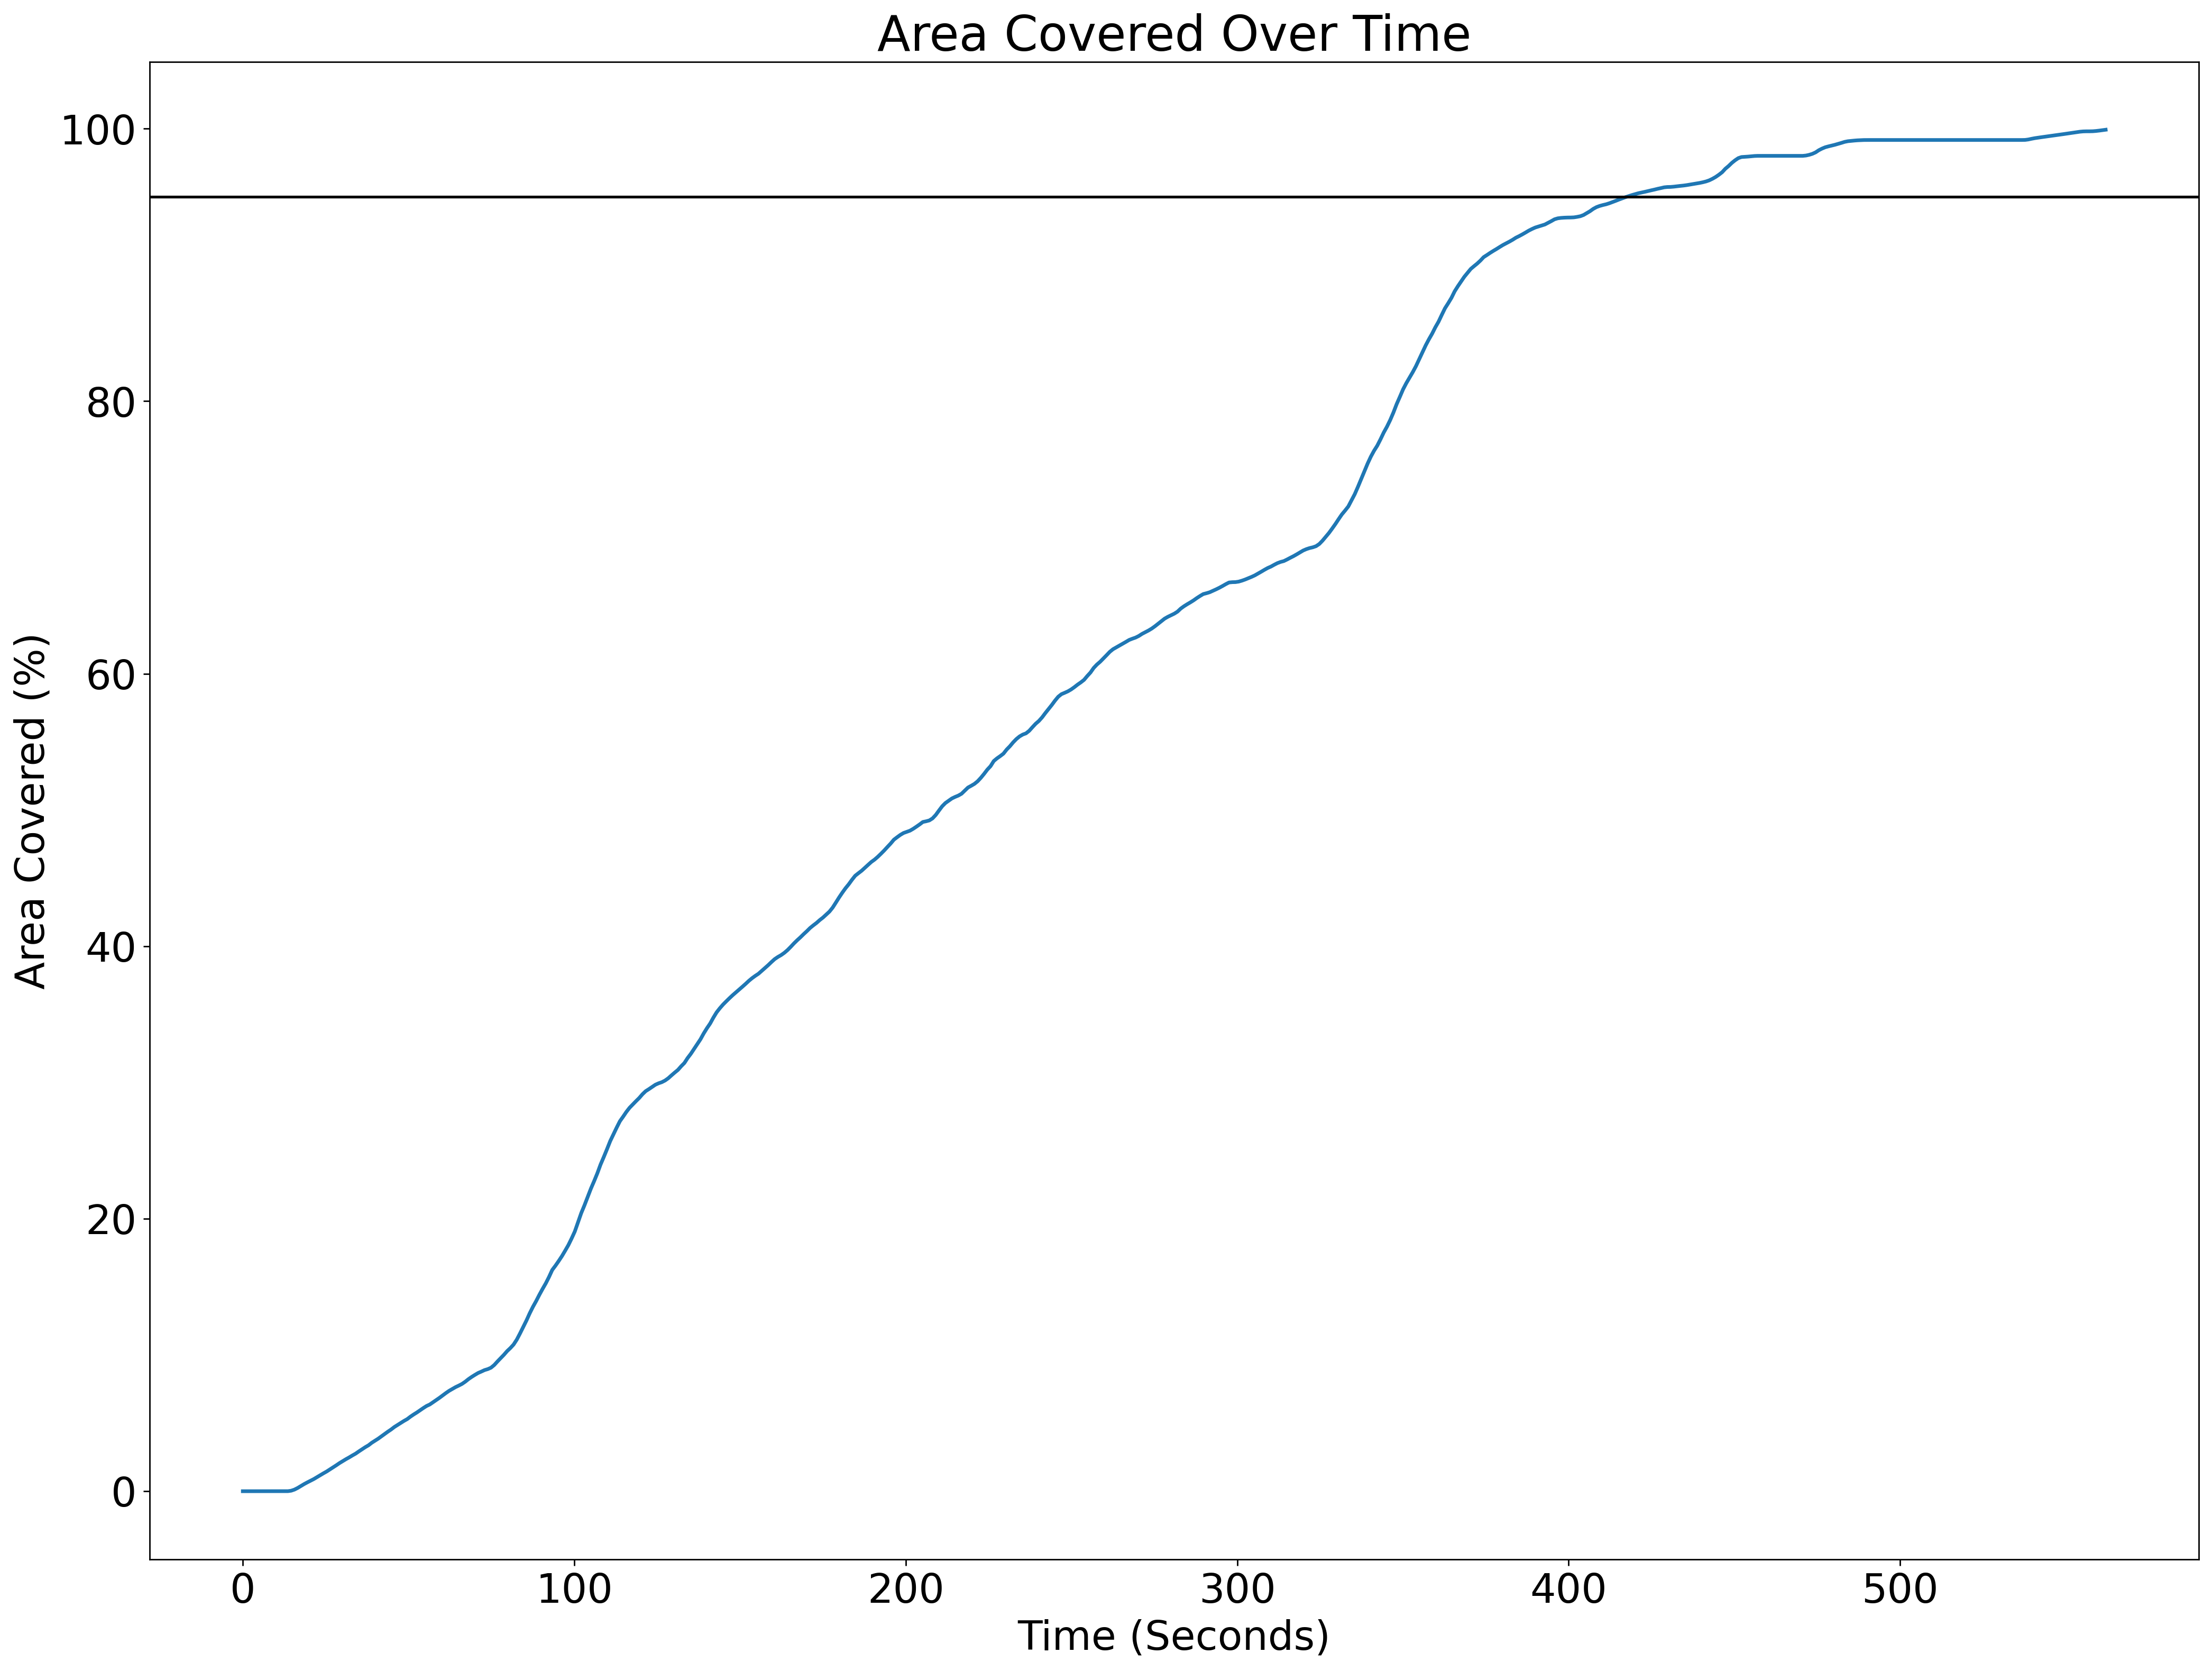

In [666]:
increasing_coverage = [covered_area_percentage_pad[0]]
for idx, value in enumerate(covered_area_percentage_pad):
    #if value > increasing_coverage[-1]:
    increasing_coverage.append(value)
time_axis = np.linspace(0, int(mission_complete_time_100[0] - time[0]), len(increasing_coverage))
pyplot.figure(1, figsize=(20, 15.0), dpi=250)
pyplot.plot(time_axis, increasing_coverage, zorder=1, lw=2)
pyplot.axhline(y=95, color=BLACK, linestyle='-')
pyplot.ylabel('Area Covered (%)')
pyplot.xlabel('Time (Seconds)')
pyplot.title('Area Covered Over Time')
pyplot.savefig(f'{b.datafolder}/area_covered_over_time.pdf', bbox_inches='tight', dpi=600)
pyplot.show()

In [667]:
list1 = drone_wps_one.tolist()
list2 = drone_wps_two.tolist()
list3 = drone_wps_three.tolist()
list4 = drone_wps_four.tolist()
counter_duplicates = 0
#any(e in list2 for e in list1) # CAN BE USED TO CHECK IF DRONES HAS TAKEN ANOTHER DRONES TASK
iter_list = [list1, list2, list3, list4]
for idx1, i in enumerate(iter_list):
    for idx2, j in enumerate(iter_list):
        if idx1 != idx2:
            be = [e in i for e in j]
            se = sum(be)
            if any(be):
                counter_duplicates += 1
                print(f'Drone{idx1+1} and Drone{idx2+1} has {se} shared task/s')
if counter_duplicates == 0:
    print('No duplicate tasks were found')

No duplicate tasks were found


In [668]:
BATTERY_STATUS_ONE = b.message_by_topic('/drone_1/current_charge_level')
BATTERY_STATUS_TWO = b.message_by_topic('/drone_2/current_charge_level')
BATTERY_STATUS_THREE = b.message_by_topic('/drone_3/current_charge_level')
BATTERY_STATUS_FOUR = b.message_by_topic('/drone_4/current_charge_level')

battery_status_msg_one = pd.read_csv(BATTERY_STATUS_ONE)
battery_status_msg_two = pd.read_csv(BATTERY_STATUS_TWO)
battery_status_msg_three = pd.read_csv(BATTERY_STATUS_THREE)
battery_status_msg_four = pd.read_csv(BATTERY_STATUS_FOUR)

In [669]:
b_status_one = battery_status_msg_one['data'].tolist()
b_status_two = battery_status_msg_two['data'].tolist()
b_status_three = battery_status_msg_three['data'].tolist()
b_status_four = battery_status_msg_four['data'].tolist()

b_status_one = b_status_one[0]
b_status_two = b_status_two[0]
b_status_three = b_status_three[0]
b_status_four = b_status_four[0]


In [670]:
total_mission_time_list = pat_status_message['Time'].tolist()
total_mission_time = total_mission_time_list[-1] - time[0]

In [671]:
# print total number of recharges per drone
RECHARGE_STATUS_ONE = b.message_by_topic('/drone_1/task_allocation/task_complete')
recharge_msg_one = pd.read_csv(RECHARGE_STATUS_ONE)
recharge_msg_one_list = recharge_msg_one.loc[recharge_msg_one['uniqueid'] == 'drone_1/recharge', 'uniqueid']

RECHARGE_STATUS_TWO = b.message_by_topic('/drone_2/task_allocation/task_complete')
recharge_msg_two = pd.read_csv(RECHARGE_STATUS_TWO)
recharge_msg_two_list = recharge_msg_two.loc[recharge_msg_two['uniqueid'] == 'drone_2/recharge', 'uniqueid']

RECHARGE_STATUS_THREE = b.message_by_topic('/drone_3/task_allocation/task_complete')
recharge_msg_three = pd.read_csv(RECHARGE_STATUS_THREE)
recharge_msg_three_list = recharge_msg_three.loc[recharge_msg_three['uniqueid'] == 'drone_3/recharge', 'uniqueid']

RECHARGE_STATUS_FOUR = b.message_by_topic('/drone_4/task_allocation/task_complete')
recharge_msg_four = pd.read_csv(RECHARGE_STATUS_FOUR)
recharge_msg_four_list = recharge_msg_four.loc[recharge_msg_four['uniqueid'] == 'drone_4/recharge', 'uniqueid']

In [672]:
# print time taken to 95% area coverage

In [673]:

f = open(f'{b.datafolder}/results.txt', "w")
print(f'Tasks completed by drone1:{len(drone_wps_one)}, drone2:{len(drone_wps_two)}, drone3:{len(drone_wps_three)}, drone4:{len(drone_wps_four)}')
f.write(f'Tasks completed by drone1:{len(drone_wps_one)}, drone2:{len(drone_wps_two)}, drone3:{len(drone_wps_three)}, drone4:{len(drone_wps_four)}\n')

print(f'Individual path length: Drone1: {line1.length}, Drone2: {line2.length}, Drone3: {line3.length}, Drone4: {line4.length}')
f.write(f'Individual path length: Drone1: {line1.length}, Drone2: {line2.length}, Drone3: {line3.length}, Drone4: {line4.length}\n')

print(f'Total area: {polygon_big.area}, Area not covered: {difference.area}, Area covered: {covered_area}')
f.write(f'Total area: {polygon_big.area}, Area not covered: {difference.area}, Area covered: {covered_area}\n')

print(f'The drones covered {covered_area_percentage} % of the total area')
f.write(f'The drones covered {covered_area_percentage} % of the total area\n')

print(f'All people found after: {all_people_found_time} seconds')
f.write(f'All people found after: {all_people_found_time} seconds\n')

print(f'Area coverage 25%: {mission_complete_time_25[0] - time[0]}, 50%:{mission_complete_time_50[0] - time[0]}, 75%:{mission_complete_time_75[0] - time[0]}, 95%:{mission_complete_time_95[0] - time[0]}seconds') # SCUFFED AT THE MOMENT
f.write(f'Area coverage 25%: {mission_complete_time_25[0] - time[0]}, 50%:{mission_complete_time_50[0] - time[0]}, 75%:{mission_complete_time_75[0] - time[0]}, 95%:{mission_complete_time_95[0] - time[0]}seconds\n')

print(f'Total mission time:{total_mission_time} seconds')
f.write(f'Total mission time:{total_mission_time} seconds\n')

print(f'Initial battery status for Drone1:{b_status_one}, Drone2:{b_status_two}, Drone3:{b_status_three}, Drone4:{b_status_four} ')
f.write(f'Initial battery status for Drone1:{b_status_one}, Drone2:{b_status_two}, Drone3:{b_status_three}, Drone4:{b_status_four}\n')

print(f'Total number of recharges for Drone1:{len(recharge_msg_one_list)}, Drone2:{len(recharge_msg_two_list)}, Drone3:{len(recharge_msg_three_list)}, Drone4:{len(recharge_msg_four_list)}')
f.write(f'Total number of recharges for Drone1:{len(recharge_msg_one_list)}, Drone2:{len(recharge_msg_two_list)}, Drone3:{len(recharge_msg_three_list)}, Drone4:{len(recharge_msg_four_list)}\n')

f.close()

Tasks completed by drone1:29, drone2:32, drone3:45, drone4:12
Individual path length: Drone1: 1653.4095709628657, Drone2: 2480.0257371958955, Drone3: 2597.181745869465, Drone4: 2417.2317754191354
Total area: 160000.0, Area not covered: 0.0, Area covered: 160000.0
The drones covered 100.0 % of the total area
All people found after: 513.2395441532135 seconds
Area coverage 25%: 103.96183037757874, 50%:219.65056133270264, 75%:370.35362911224365, 95%:452.0994210243225seconds
Total mission time:776.3629961013794 seconds
Initial battery status for Drone1:64.0, Drone2:40.0, Drone3:94.0, Drone4:79.0 
Total number of recharges for Drone1:1, Drone2:1, Drone3:1, Drone4:1


In [674]:
mission_complete_time_list = odom_status_message_one.loc[odom_status_message_one['header.seq'] == drone_odom_hseq_one[-1], 'Time'].tolist()
print(f'Area coverage at 95% at: {mission_complete_time_list[0] - time[0]} seconds')


Area coverage at 95% at: 776.2691521644592 seconds


In [675]:
time[0]

1620406694.255744